In [2]:
import numpy as np

In [3]:
import torch

In [4]:
import matplotlib.pyplot as plt

In [3]:
def compute_loss(out, l, n_triplets=200):
    def generate_triplets(n_triplets):
        ai = np.random.randint(low=0, high=out.shape[2]*out.shape[3], size=(n_triplets,))

        classes, inv_map = np.unique(l, return_inverse=True)
        n_classes = len(classes)
        inv_map = inv_map.reshape(l.shape[1], l.shape[2])
        inv_map_flat = inv_map.reshape(-1)

    #     anchor_classes = inv_map[ix, iy]

        class_lookup = (np.arange(n_classes, dtype=np.int32).reshape((1, 1, n_classes)) !=
                        inv_map.reshape(l.shape[1], l.shape[2], 1))
        class_lookup = np.transpose(class_lookup, axes=[2, 0, 1])

        lneg = []
        lpos = []
        for i in range(n_classes):
            lneg.append(np.transpose(class_lookup[i].reshape(-1).nonzero()).reshape((-1)))
            lpos.append(np.transpose(np.logical_not(class_lookup[i]).reshape(-1).nonzero()).reshape((-1)))

        ni, pi = [], []
        for i in range(n_triplets):
            ni.append( np.random.choice(lneg[inv_map_flat[ai[i]]]))
            pi.append( np.random.choice(lpos[inv_map_flat[ai[i]]]))

        return (torch.tensor(ai, dtype=torch.int32),
                torch.tensor(pi, dtype=torch.int32),
                torch.tensor(ni, dtype=torch.int32))

    
    ta, tp, tn = generate_triplets(n_triplets)
    ta.cuda()
    tp.cuda()
    tn.cuda()

In [19]:
def compute_loss(out, l, loss_fn, target, reg=1e-3, n_triplets=200):
    def generate_triplets(n_triplets):
        ai = np.random.randint(low=0, high=out.shape[2]*out.shape[3], size=(n_triplets,))

        classes, inv_map = np.unique(l, return_inverse=True)
        n_classes = len(classes)
        inv_map = inv_map.reshape(l.shape[1], l.shape[2])
        inv_map_flat = inv_map.reshape(-1)

        class_lookup = (np.arange(n_classes, dtype=np.int32).reshape((1, 1, n_classes)) !=
                        inv_map.reshape(l.shape[1], l.shape[2], 1))
        class_lookup = np.transpose(class_lookup, axes=[2, 0, 1])

        lneg = []
        lpos = []
        for i in range(n_classes):
            lneg.append(np.transpose(class_lookup[i].reshape(-1).nonzero()).reshape((-1)))
            lpos.append(np.transpose(np.logical_not(class_lookup[i]).reshape(-1).nonzero()).reshape((-1)))

        ni, pi = [], []
        for i in range(n_triplets):
            ni.append( np.random.choice(lneg[inv_map_flat[ai[i]]]))
            pi.append( np.random.choice(lpos[inv_map_flat[ai[i]]]))

        return (torch.tensor(ai, dtype=torch.long),
                torch.tensor(pi, dtype=torch.long),
                torch.tensor(ni, dtype=torch.long))
    
    ta, tp, tn = generate_triplets(n_triplets)
    ta.cuda()
    tp.cuda()
    tn.cuda()

    n_dim = out.shape[1]
    
    out = out.view(n_dim, -1)
    
    l2_norm = (out[:, ta].pow(2).sum(dim=0).mean() +
               out[:, ta].pow(2).sum(dim=0).mean() +
               out[:, ta].pow(2).sum(dim=0).mean())
            
    distp = (out[:, ta] - out[:, tp]).pow(2).sum(dim=0)
    distn = (out[:, ta] - out[:, tn]).pow(2).sum(dim=0)

    loss = loss_fun(distn, distp, target) + l2_norm * 1e-3

    return loss

In [3]:
%%time
cl = compute_loss(np.ones(shape=(1, 30, 2, 2)), np.array([[[3, 0], [1, 1]]]), n_triplets=20)

NameError: name 'compute_loss' is not defined

In [66]:
import deeptriplet.triplet
import importlib

In [4]:
loss1 = RandomTriplet()

NameError: name 'RandomTriplet' is not defined

In [4]:
x1 = torch.tensor(np.random.rand(1, 30, 200, 100), device='cuda:0', dtype=torch.float32)
x2 = torch.tensor(np.random.randint(0, high=20, size=(1,200,100)))

In [5]:
loss = deeptriplet.triplet.RandomMinimumTriplet(n_points=200)

In [16]:
%%time
cl = loss.compute_loss(x1, x2)

CPU times: user 128 ms, sys: 4 ms, total: 132 ms
Wall time: 142 ms


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets
import torch.utils.data as data

In [8]:
import ptsemseg
import ptsemseg.loader

In [9]:
data_loader = ptsemseg.loader.get_loader("pascal")

data_aug = None

t_loader = data_loader(
        "/srv/glusterfs/yardima/datasets/voc12/VOCdevkit/VOC2012",
        is_transform=True,
        split="train_aug",
        img_size=("same", "same"),
        augmentations=data_aug)


v_loader = data_loader("/srv/glusterfs/yardima/datasets/voc12/VOCdevkit/VOC2012",
                        is_transform=True,
                        split="val",
                        img_size=("same", "same"),)

trainloader = data.DataLoader(t_loader,
                                  batch_size=1,
                                  num_workers=2,
                                  shuffle=True)

valloader = data.DataLoader(v_loader,
                                batch_size=1,
                                num_workers=2)

In [67]:
net = deeptriplet.models.FCN8Embedding(embedding_dim=30)
pretrained_state = torch.load("/srv/glusterfs/yardima/runs/pretrained-models/fcn8s_pascal_best_model.pkl",
                              map_location=lambda storage, loc: storage)
                              

net = nn.DataParallel(net)
net.load_state_dict(pretrained_state['model_state'], strict=False)
net.cuda();

In [70]:
triplet_fun = deeptriplet.triplet.LocalTriplet(sigma_neg=20, sigma_pos=10)
triplet_fun_test = deeptriplet.triplet.RandomTriplet(n_triplets=500)
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-7)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 30, 42], gamma=0.3)

In [71]:
for ii, sample_batched in enumerate(trainloader):
    inputs, labels = sample_batched

    optimizer.zero_grad()
    
    inputs = inputs.cuda()
    
    outputs = net.forward(inputs)
    loss = triplet_fun.compute_loss(outputs, labels)
    
    loss.backward()
    
    optimizer.step()

Process Process-15:
Process Process-16:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/hom

KeyboardInterrupt: 

  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/PIL/Image.py", line 2609, in open
    fp = builtins.open(filename, "rb")
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
KeyboardInterrupt
KeyboardInterrupt


In [106]:
np.append(np.array([1]), np.array([1]))

array([1, 1])

In [19]:
x3 = torch.tensor(np.random.rand(5, 30), device='cuda:0', dtype=torch.float32)
x4 = torch.tensor(np.random.rand(7, 30), device='cuda:0', dtype=torch.float32)

a = torch.cat((x3, x4), 0)

In [21]:
def similarity_matrix(mat):
        # get the product x * y
        # here, y = x.t()
        r = torch.mm(mat, mat.t())
        # get the diagonal elements
        diag = r.diag().unsqueeze(0)
        diag = diag.expand_as(r)
        # compute the distance matrix
        D = diag + diag.t() - 2*r
        return D

In [24]:
similarity_matrix(a)

tensor([[0.0000, 4.7875, 6.5509, 3.6582, 4.9568, 4.8206, 6.2432, 5.2171, 3.8672,
         5.6991, 3.6412, 5.6647],
        [4.7875, 0.0000, 6.3958, 4.8783, 4.3987, 4.2929, 6.2774, 4.6088, 3.1215,
         5.2489, 3.9696, 6.3064],
        [6.5509, 6.3958, 0.0000, 4.7901, 3.5289, 5.7253, 4.6814, 4.6239, 5.9310,
         5.0222, 7.0740, 5.5432],
        [3.6582, 4.8783, 4.7901, 0.0000, 6.7585, 5.2093, 4.2621, 4.5627, 3.2990,
         3.2383, 4.4473, 4.4385],
        [4.9568, 4.3987, 3.5289, 6.7585, 0.0000, 4.1653, 4.4495, 3.7173, 4.8979,
         5.7958, 6.2944, 4.3810],
        [4.8206, 4.2929, 5.7253, 5.2093, 4.1653, 0.0000, 6.4525, 5.3264, 4.6413,
         5.1812, 4.2690, 4.9387],
        [6.2432, 6.2774, 4.6814, 4.2621, 4.4495, 6.4525, 0.0000, 4.8705, 6.1602,
         4.9229, 6.3036, 4.5867],
        [5.2171, 4.6088, 4.6239, 4.5627, 3.7173, 5.3264, 4.8705, 0.0000, 3.8980,
         5.9005, 5.7550, 4.1147],
        [3.8672, 3.1215, 5.9310, 3.2990, 4.8979, 4.6413, 6.1602, 3.8980, 0.0000,

In [30]:
prod = torch.mm(x3, x4.t())
mag1 = x3.pow(2).sum(dim=1).view(-1, 1)
mag2 = x4.pow(2).sum(dim=1).view(1, -1)

S = mag1 + mag2 - 2 * prod

In [31]:
S

tensor([[4.8206, 6.2432, 5.2171, 3.8672, 5.6991, 3.6412, 5.6647],
        [4.2929, 6.2774, 4.6088, 3.1215, 5.2489, 3.9696, 6.3064],
        [5.7253, 4.6814, 4.6239, 5.9310, 5.0222, 7.0740, 5.5432],
        [5.2094, 4.2621, 4.5627, 3.2990, 3.2383, 4.4473, 4.4385],
        [4.1653, 4.4495, 3.7173, 4.8979, 5.7958, 6.2944, 4.3810]],
       device='cuda:0')

In [35]:
a = np.random.rand(3, 9)

In [41]:
a[[1,0], [7,8]]

array([0.6972077, 0.4375089])

In [36]:
ai_x = np.random.randint(low=0, high=3, 
                                size=(200,))
ai_y = np.random.randint(low=0, high=9, 
                                size=(200,))

ai = ai_x * 9 + ai_y

In [44]:
a[-1:1, -1:3]

array([], shape=(0, 0), dtype=float64)

In [65]:
labels = np.zeros(shape=(5, 6))
halfw = labels.shape[0] // 2
halfh = labels.shape[1] // 2

ai_x = 4
ai_y = 4

prange = t.probs_precomputed[t.ox - ai_x: t.ox - ai_x + labels.shape[0],
                             t.oy - ai_y: t.oy - ai_y + labels.shape[1]]

print(prange)

[[0.72614904 0.77880078 0.81873075 0.84366482 0.85214379 0.84366482]
 [0.77880078 0.83527021 0.87809543 0.90483742 0.91393119 0.90483742]
 [0.81873075 0.87809543 0.92311635 0.95122942 0.96078944 0.95122942]
 [0.84366482 0.90483742 0.95122942 0.98019867 0.99004983 0.98019867]
 [0.85214379 0.91393119 0.96078944 0.99004983 0.         0.99004983]]


In [24]:
x1 = torch.tensor(np.random.rand(1, 30, 200, 100), device='cuda:0', dtype=torch.float32)
x2 = torch.tensor(np.random.randint(0, high=20, size=(1,200,100)))

In [114]:
t = LocalTriplet(max_size=1499, sigma_neg=30, sigma_pos=20)

In [115]:
output = torch.rand(1, 30, l.shape[1], l.shape[2])

In [107]:
%%timeit -n 1 -r 15
x = t.generate_triplets(output, l)

430 ms ± 65.4 ms per loop (mean ± std. dev. of 15 runs, 1 loop each)


In [116]:
%%timeit -n 1 -r 15
x = t.generate_triplets(output, l)

382 ms ± 50.1 ms per loop (mean ± std. dev. of 15 runs, 1 loop each)


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x2b9137bd3cc0>>
Traceback (most recent call last):
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/yardima/.pye

tensor(0)
tensor(0)
tensor(3)


(0, 500)

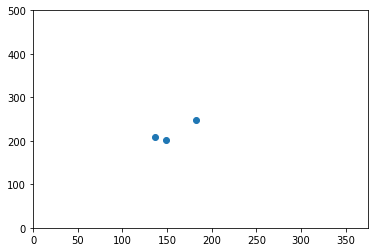

In [79]:
itl = iter(trainloader)

i,l = next(itl)

t = LocalTriplet(max_size=1499, sigma_neg=30, sigma_pos=20)

a, p, n = t.generate_triplets(torch.rand(1, 30, l.shape[1], l.shape[2]), l)

ax = a[0] // l.shape[2]
ay = a[0] % l.shape[2]

px = p[0] // l.shape[2]
py = p[0] % l.shape[2]

nx = n[0] // l.shape[2]
ny = n[0] % l.shape[2]

print(l[0, ax, ay])
print(l[0, px, py])
print(l[0, nx, ny])

plt.scatter(np.array([ax, px, nx]), np.array([ay, py, ny]))
axes = plt.gca()
axes.set_xlim([0,l.shape[1]])
axes.set_ylim([0,l.shape[2]])

In [39]:
for i in range(200):
    assert(a.reshape(-1)[ai[i]] == a[ai_x[i], ai_y[i]])

In [50]:
import random

In [52]:
random.random()

0.19393193711517753

In [113]:
class LocalTriplet:

    def __init__(self, n_triplets=200, *, sigma_pos=10, sigma_neg=80, margin=1, l2_penalty=1e-3, max_size=1599):
        self.margin = margin
        self.l2_penalty = l2_penalty
        self.n_triplets =  n_triplets

        self.loss_fun = nn.MarginRankingLoss(margin=margin)
        self.target = torch.FloatTensor(n_triplets).fill_(1).cuda()

        ox = oy = max_size // 2
        
        X, Y = np.meshgrid(range(max_size), range(max_size))
        p = - ((X - ox) ** 2 + (Y - oy) ** 2) / (sigma_pos ** 2)
        p = np.exp(p)
        
        self.ox = ox
        self.oy = oy
        self.probs_precomputed_pos = np.copy(p)
        self.probs_precomputed_neg = np.exp(- ((X - ox) ** 2 + (Y - oy) ** 2) / (sigma_neg ** 2))
        self.probs_precomputed_pos[ox, oy] = 0.
        

    def generate_triplets(self, output, labels):
        ai_x = np.random.randint(low=0, high=output.shape[2], 
                                size=(self.n_triplets,))
        ai_y = np.random.randint(low=0, high=output.shape[3], 
                                size=(self.n_triplets,))
        
        ai = output.shape[3] * ai_x + ai_y
        
        classes, inv_map = np.unique(labels, return_inverse=True)
        n_classes = len(classes)
        inv_map = inv_map.reshape(labels.shape[1], labels.shape[2])
        inv_map_flat = inv_map.reshape(-1)

        class_lookup = (np.arange(n_classes, dtype=np.int32).reshape((1, 1, n_classes)) !=
                        inv_map.reshape(labels.shape[1], labels.shape[2], 1))
        class_lookup = np.transpose(class_lookup, axes=[2, 0, 1])

        lneg = []
        lpos = []
        for i in range(n_classes):
            ni_temp = np.transpose(class_lookup[i].reshape(-1).nonzero()).reshape((-1))
            pi_temp = np.transpose(np.logical_not(class_lookup[i]).reshape(-1).nonzero()).reshape((-1))
            
            lneg.append(ni_temp)
            lpos.append(pi_temp)

        rs = np.random.rand(2 * self.n_triplets)
            
        ni, pi = [], []
        for i in range(self.n_triplets):
            prangepos = self.probs_precomputed_pos[self.ox - ai_x[i]: self.ox - ai_x[i] + labels.shape[1],
                                                    self.oy - ai_y[i]: self.oy - ai_y[i] + labels.shape[2]]
            prangeneg = self.probs_precomputed_neg[self.ox - ai_x[i]: self.ox - ai_x[i] + labels.shape[1],
                                                    self.oy - ai_y[i]: self.oy - ai_y[i] + labels.shape[2]]
            prangeneg = prangeneg.reshape(-1)
            prangepos = prangepos.reshape(-1)
            
            prob_neg = prangeneg[lneg[inv_map_flat[ai[i]]]]
            prob_pos = prangepos[lpos[inv_map_flat[ai[i]]]]
  
            prob_pos = np.cumsum((prob_pos / prob_pos.sum()))
            prob_neg = np.cumsum((prob_neg / prob_neg.sum()))
            
            ii1 = np.searchsorted(prob_pos, rs[2 * i])
            ii2 = np.searchsorted(prob_neg, rs[2 * i + 1])

#             ii1 = np.searchsorted(prob_pos, random.random())
#             ii2 = np.searchsorted(prob_neg, random.random())

            pi.append( lpos[inv_map_flat[ai[i]]][ii1])
            ni.append( lneg[inv_map_flat[ai[i]]][ii2])

        return (torch.tensor(ai, dtype=torch.long),
                torch.tensor(pi, dtype=torch.long),
                torch.tensor(ni, dtype=torch.long))

    def compute_loss(self, output, labels):
        ta, tp, tn = self.generate_triplets(output, labels)
        ta.cuda()
        tp.cuda()
        tn.cuda()

        n_dim = output.shape[1]
        
        output = output.view(n_dim, -1)
        
        l2_norm = (output[:, ta].pow(2).sum(dim=0).mean() +
                    output[:, tp].pow(2).sum(dim=0).mean() +
                    output[:, tn].pow(2).sum(dim=0).mean())
                
        distp = (output[:, ta] - output[:, tp]).pow(2).sum(dim=0)
        distn = (output[:, ta] - output[:, tn]).pow(2).sum(dim=0)

        loss = self.loss_fun(distn, distp, self.target) + l2_norm * self.l2_penalty

        return loss

In [77]:
np.random.rand(12)

array([0.18725521, 0.77991908, 0.24225463, 0.07013761, 0.79544158,
       0.49492709, 0.2060947 , 0.41480206, 0.16340681, 0.580928  ,
       0.15326825, 0.62716341])

In [28]:
t = LocalTriplet(max_size=501, sigma=90)
t.probs_precomputed

array([[1.98575042e-07, 2.11192916e-07, 2.24557104e-07, ...,
        2.24557104e-07, 2.11192916e-07, 1.98575042e-07],
       [2.11192916e-07, 2.24612557e-07, 2.38825933e-07, ...,
        2.38825933e-07, 2.24612557e-07, 2.11192916e-07],
       [2.24557104e-07, 2.38825933e-07, 2.53938725e-07, ...,
        2.53938725e-07, 2.38825933e-07, 2.24557104e-07],
       ...,
       [2.24557104e-07, 2.38825933e-07, 2.53938725e-07, ...,
        2.53938725e-07, 2.38825933e-07, 2.24557104e-07],
       [2.11192916e-07, 2.24612557e-07, 2.38825933e-07, ...,
        2.38825933e-07, 2.24612557e-07, 2.11192916e-07],
       [1.98575042e-07, 2.11192916e-07, 2.24557104e-07, ...,
        2.24557104e-07, 2.11192916e-07, 1.98575042e-07]])

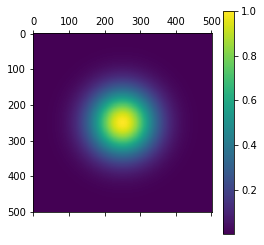

In [29]:
plt.matshow(t.probs_precomputed)
plt.colorbar()

In [1]:
l = [3, 4]

In [2]:
l[1] += 1